In [235]:
import time
import matplotlib.pyplot as plt
import numpy as np
from dropbot import SerialProxy
import pandas as pd

%matplotlib inline

def plot_and_fit(x, y):
    plt.plot(x, y, 'o')
    p = np.polyfit(x, y, 1)
    plt.plot(x, x * p[0] + p[1], 'k--')
    return p

try:
    del proxy
except:
    pass

# Connect to the connected DropBot and print it's properties
proxy = SerialProxy()

print proxy.properties

print "\nuuid\t\t\t%s\n" % proxy.uuid

#proxy.reset_config()
proxy.update_config(max_voltage=150, i2c_address=10)

print "i2c_scan:", proxy.i2c_scan()
print "soft_i2c_scan:", proxy.soft_i2c_scan()

proxy.initialize_switching_boards()

print "number of channels:", proxy.number_of_channels

print "\nconfig:"
print proxy.config

base_node_software_version                                                     
package_name                                                            dropbot
display_name                                                            DropBot
manufacturer                                                        Wheeler Lab
url                           http://github.com/wheeler-microfluidics/dropbo...
software_version                                                     1.8.post21
dtype: object

uuid			0000a1fa-3300-85a1-1000-2f00454e5337

i2c_scan: [10 32 33 34]
soft_i2c_scan: [44]
number of channels: 120

config:
max_voltage                        150
R7                             9637.15
min_frequency                      100
switching_board_i2c_address         32
max_frequency                    10000
pot_max                        47248.2
i2c_address                         10
id                                    
dtype: object


rms_error = 2.3%


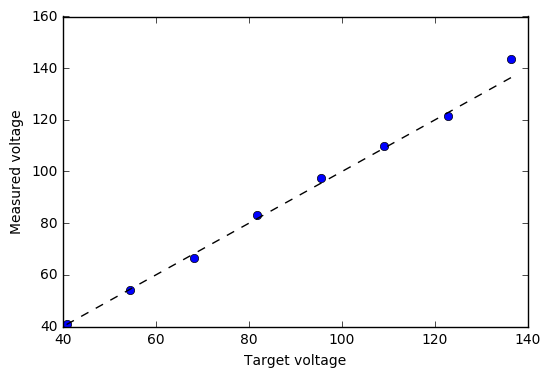

In [236]:
# test the measured voltage for a range of target voltages
proxy.voltage = proxy.min_waveform_voltage
proxy.hv_output_enabled = True
measured_voltage = []

voltage = np.linspace(proxy.min_waveform_voltage,
                      proxy.max_waveform_voltage,
                      10)[1:-1]
for v in voltage:
    proxy.voltage = v
    time.sleep(.5)
    measured_voltage.append(proxy.measured_voltage)

measured_voltage = np.array(measured_voltage)
proxy.voltage = proxy.min_waveform_voltage + 5

plt.figure()
# plot the measured vs target votage
plt.plot(voltage, measured_voltage, 'o')
plt.plot(voltage, voltage, 'k--')
plt.xlabel('Target voltage')
plt.ylabel('Measured voltage')

# calculate the average rms error
r = measured_voltage - voltage
print 'rms_error = %.1f%%' % (100 * np.sqrt(np.mean((r / voltage)**2)))

[ 0.02390435  0.00471627]
pot_max = 47808.6910162
R7 = 9432.54276733
min_voltage = 26.9548858987
max_voltage = 159.7739278


1

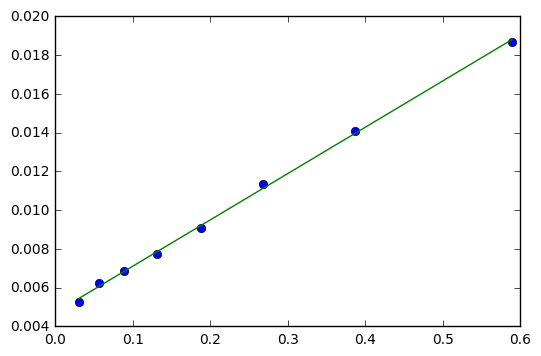

In [237]:
# update the calibration values
R6 = 2e6
R7 = proxy.config.R7
pot_max = proxy.config.pot_max

R_pot = R6 / ( 2 * voltage / 1.5 - 1 ) - R7
x = R_pot / pot_max

plt.plot(x, 1 / (2 * np.array(measured_voltage) / 1.5 - 1), 'o')
p = np.polyfit(x, 1 / (2 * np.array(measured_voltage) / 1.5 - 1), 1)
print p
plt.plot(x, x*p[0] + p[1])
pot_max = p[0]*R6
R7 = np.abs(p[1]*R6)

print 'pot_max =', pot_max
print 'R7 =', R7
max_voltage = 1.5 / 2.0 * (R6 / R7 + 1)
min_voltage = 1.5 / 2.0 * (R6 / (pot_max + R7) + 1)
print 'min_voltage =', min_voltage 
print 'max_voltage =', max_voltage
proxy.update_config(pot_max=pot_max,
                    R7=R7,
                    #min_voltage=min_voltage,
                    #max_voltage=max_voltage
                   )

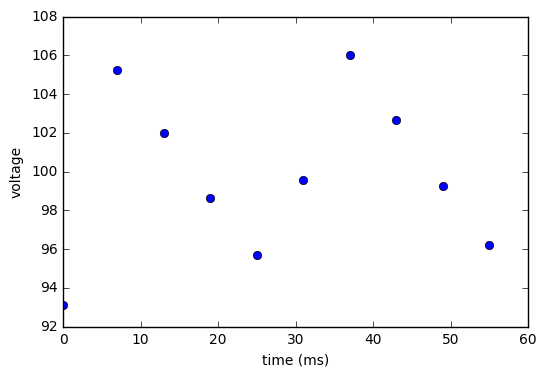

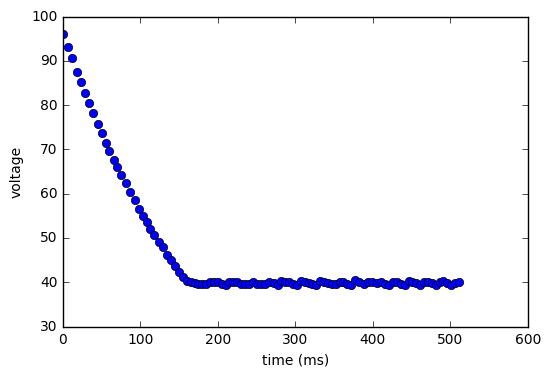

In [144]:
# test how long it takes to change the actuation voltage
proxy.voltage = 40
time.sleep(5)
proxy.voltage = 100
t, v = zip(*[(time.time(), proxy.measured_voltage) for x in range(10)])
t = np.array(t) - t[0]
plt.figure()
plt.plot(1e3*t, v, 'o')
plt.ylabel('voltage')
plt.xlabel('time (ms)')

proxy.voltage = 40 
t, v = zip(*[(time.time(), proxy.measured_voltage) for x in range(100)])
t = np.array(t) - t[0]
plt.figure()
plt.plot(1e3*t, v, 'o')
plt.ylabel('voltage')
plt.xlabel('time (ms)')

voltage		vgnd			vrms			vabs		capacitance
50		-0.00203178977966	0.00303387509813	0.00211818775177	6.35456325531e-12
75		-0.00206948661804	0.00434635671271	0.00300301116943	6.00602233887e-12
100		-0.00205495834351	0.00561315115878	0.00413415527344	6.20123291016e-12


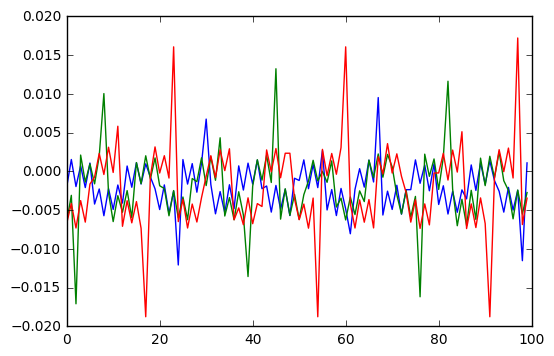

In [154]:
proxy.hv_output_enabled = True
proxy.frequency = 10e3

summary_df = pd.DataFrame()

plt.figure()
print 'voltage\t\tvgnd\t\t\tvrms\t\t\tvabs\t\tcapacitance'

proxy.select_on_board_test_capacitor(0)

for voltage in [50, 75, 100]:
    proxy.voltage = voltage
    time.sleep(.5)
    #sampling_rate, adc_settings, df_volts, df_adc_results = proxy.analog_reads('A6', 200)
    sampling_rate, adc_settings, df_volts, df_adc_results = \
        proxy.analog_reads('PGA0', 100, gain_power=5)
    vgnd = np.mean(df_volts)[0]
    plt.plot(df_volts.values)
    vrms = np.sqrt(np.mean((df_volts - vgnd)**2))[0]
    vabs = np.mean(np.abs(df_volts - vgnd))[0]
    c = vabs / voltage * 0.15e-6
    print '%s\t\t%s\t%s\t%s\t%s' % (voltage, vgnd, vrms, vabs, c)
    summary_df = summary_df.append(pd.DataFrame(dict(voltage=[voltage], vgnd=[vgnd], vrms=[vrms], vabs=[vabs])),
                                   ignore_index=True)

proxy.hv_output_enabled = False

-0.0114925283239


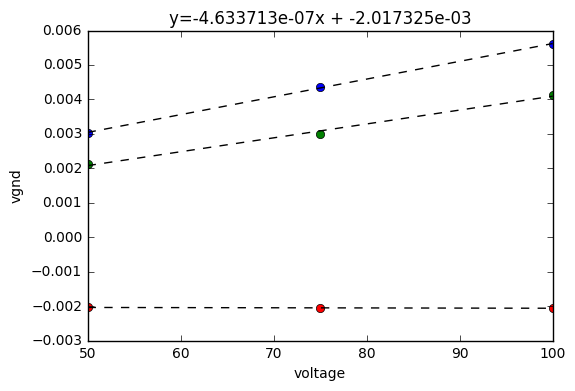

In [157]:
p1 = plot_and_fit(summary_df['voltage'], summary_df['vrms'])
plt.xlabel('voltage')
plt.ylabel('vrms')
plt.title('y=%ex + %e' % (p1[0], p1[1]))

p1 = plot_and_fit(summary_df['voltage'], summary_df['vabs'])
plt.xlabel('voltage')
plt.ylabel('vabs')
plt.title('y=%ex + %e' % (p1[0], p1[1]))

p2 = plot_and_fit(summary_df['voltage'], summary_df['vgnd'])
plt.xlabel('voltage')
plt.ylabel('vgnd')
plt.title('y=%ex + %e' % (p2[0], p2[1]))

print p2[0] / p1[0]

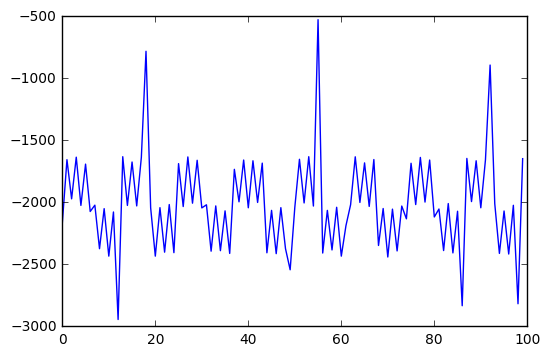

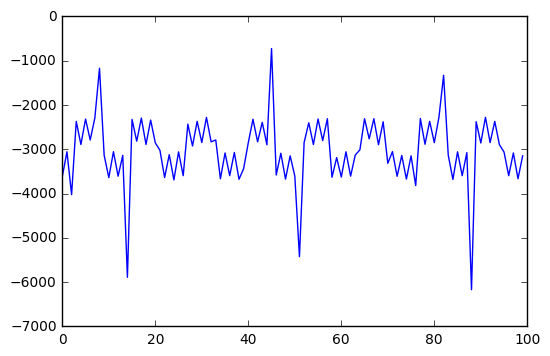

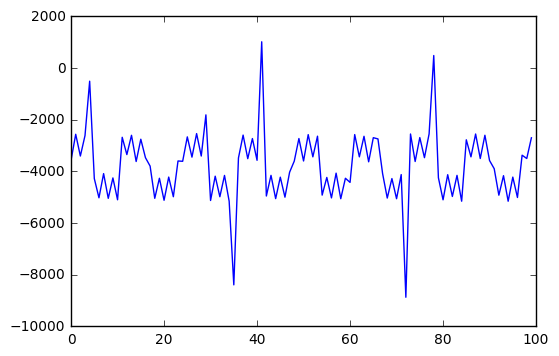

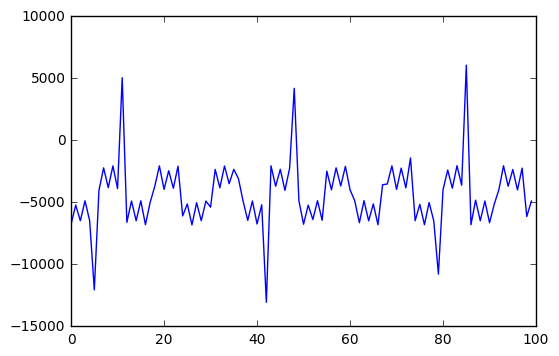

In [159]:
# test the programmable gain
proxy.frequency = 10e3
proxy.hv_output_enabled = True

plt.figure()
proxy.voltage = 100
for i in range(4):
    plt.figure()
    sampling_rate, adc_settings, df_volts, df_adc_results = proxy.analog_reads('PGA0', 100, gain_power=i)
    plt.plot(df_adc_results.values)

In [238]:
# measure the current on both sides of the boost converter
proxy.hv_output_enabled = True

voltage = np.linspace(proxy.min_waveform_voltage,
                      proxy.max_waveform_voltage,
                      5)[1:-1]

n_samples = 400
print "label\t\tv\t\trms"

summary_df = pd.DataFrame()
for label in ['A1', 'A2', 'A3']:
    for v in voltage:
        proxy.voltage = v
        time.sleep(.5)
        sampling_rate, adc_settings, df_volts, df_adc_results = proxy.analog_reads(label, n_samples)
        summary_df = summary_df.append(pd.DataFrame(dict(voltage=v*np.ones(len(df_volts)),
                                                         label=[label]*len(df_volts),
                                                         mean=df_volts.values.flatten())),
                                       ignore_index=True)
        print "%s\t\t%.3f\t\t%.3f" % (label, v, np.sqrt(np.mean(df_volts**2))[0])

proxy.hv_output_enabled = False

label		v		rms
A1		51.564		1.025
A1		76.173		1.510
A1		100.782		1.967
A1		125.391		2.668
A2		51.564		0.235
A2		76.173		0.276
A2		100.782		0.376
A2		125.391		0.370
A3		51.564		0.007
A3		76.173		0.014
A3		100.782		0.000
A3		125.391		0.023


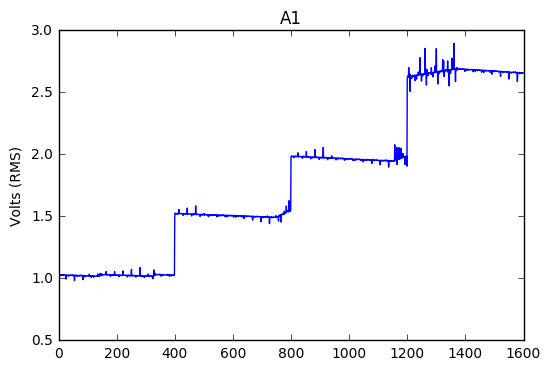

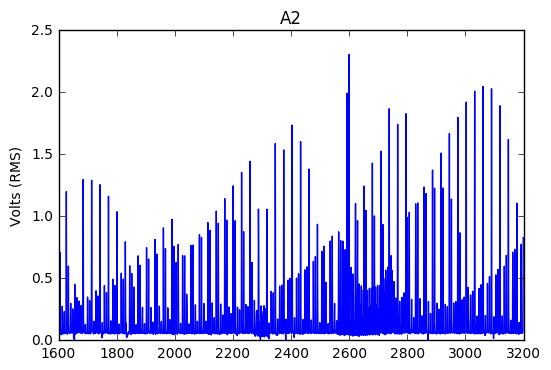

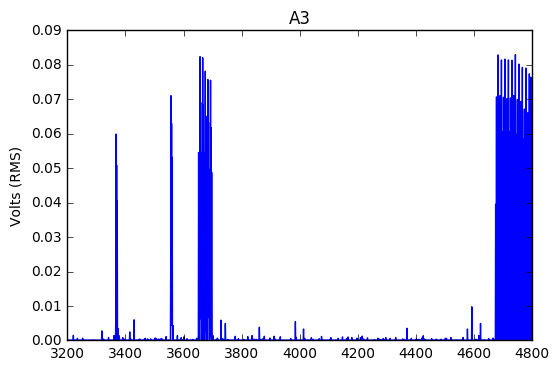

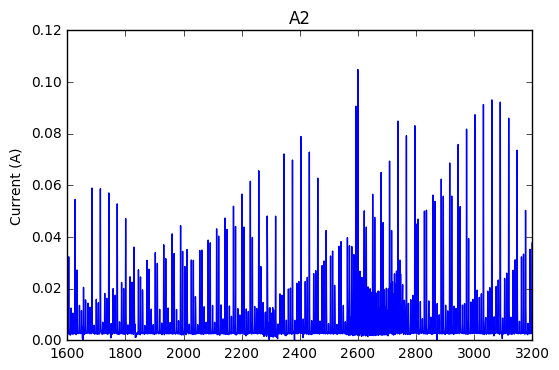

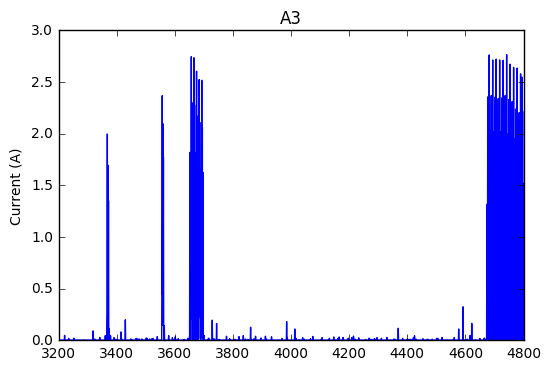

In [239]:
summary_df['rms'] = summary_df['mean']**2
for label, group in summary_df.groupby('label'):
    plt.figure()
    plt.plot(group['mean'])
    plt.title(label)
    plt.ylabel('Volts (RMS)')

plt.figure()
plt.plot(summary_df[summary_df['label']=='A2']['mean'] / (51e3 / 5.1e3 * 2.2))
plt.title('A2')
plt.ylabel('Current (A)')

plt.figure()
plt.plot(summary_df[summary_df['label']=='A3']['mean'] / 0.03)
plt.title('A3')
plt.ylabel('Current (A)')

[  4.03102487e-05   2.59421380e-03]
[ 0.00462513 -0.03353359]


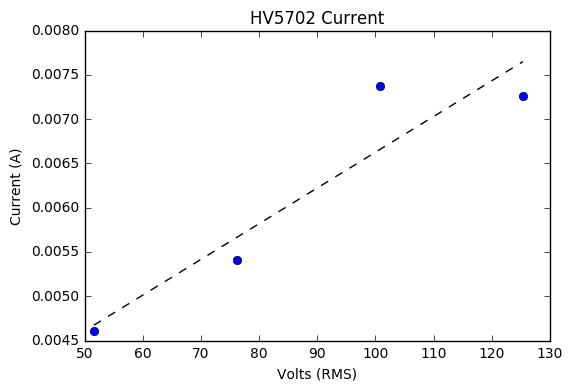

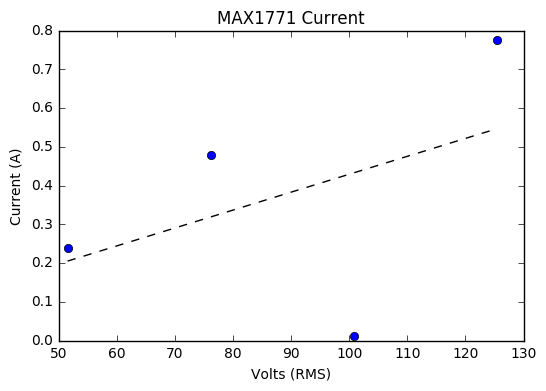

In [240]:
"""
i = v_out / ( RB / RA * Rout )

RB = 51e3
RA = 5.1e3
Rout = 2.2
"""

plt.figure()
group = summary_df[summary_df['label']=='A2']
grouped = group.groupby('voltage', as_index=False).aggregate(np.mean)
grouped['rms'] = np.sqrt(grouped['rms'])

x = grouped['voltage']
y = grouped['rms'] / 51
p = plot_and_fit(x, y)
print p
plt.title('HV5702 Current')
plt.xlabel('Volts (RMS)')
plt.ylabel('Current (A)')


plt.figure()
group = summary_df[summary_df['label']=='A3']
grouped = group.groupby('voltage', as_index=False).aggregate(np.mean)
grouped['rms'] = np.sqrt(grouped['rms'])

x = grouped['voltage']
y = grouped['rms'] / 0.03
p = plot_and_fit(x, y)
print p
plt.title('MAX1771 Current')
plt.xlabel('Volts (RMS)')
plt.ylabel('Current (A)')

In [241]:
proxy.voltage = 120
proxy.hv_output_enabled = True

n_samples = 400
print "label\t\ti\t\trms"

capacitance = np.array([0, 1e-12, 100e-12, 470e-12])

summary_df = pd.DataFrame()
for label in ['A1', 'A2', 'A3']:
    for i, c in enumerate(capacitance):
        proxy.select_on_board_test_capacitor(i)
        time.sleep(.5)
        sampling_rate, adc_settings, df_volts, df_adc_results = proxy.analog_reads(label, n_samples)
        summary_df = summary_df.append(pd.DataFrame(dict(voltage=v*np.ones(len(df_volts)),
                                                         c=c*np.ones(len(df_volts)),
                                                         label=[label]*len(df_volts),
                                                         mean=df_volts.values.flatten())),
                                       ignore_index=True)
        print "%s\t\t%.3f\t\t%.3f" % (label, i, np.sqrt(np.mean(df_volts**2))[0])

summary_df['rms'] = summary_df['mean']**2
proxy.select_on_board_test_capacitor(-1)
proxy.hv_output_enabled = False

label		i		rms
A1		0.000		2.341
A1		1.000		2.515
A1		2.000		2.329
A1		3.000		2.434
A2		0.000		0.346
A2		1.000		0.352
A2		2.000		0.335
A2		3.000		0.342
A3		0.000		0.004
A3		1.000		0.002
A3		2.000		0.010
A3		3.000		0.001


[ -3.23952368e+05   5.65455615e-03]
[ -1.26571378e+08   7.30618569e-02]


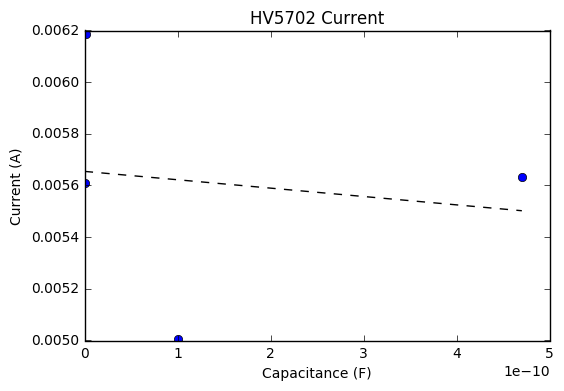

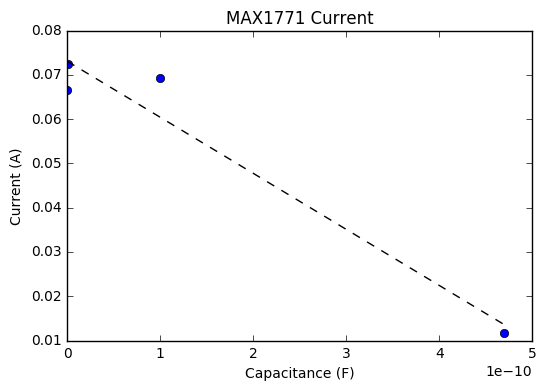

In [170]:
group = summary_df[summary_df['label']=='A2']
grouped = group.groupby('c', as_index=False).aggregate(np.mean)
grouped['rms'] = np.sqrt(grouped['rms'])
x = grouped['c']
y = grouped['rms'] / 51
p = plot_and_fit(x, y)
print p
plt.title('HV5702 Current')
plt.xlabel('Capacitance (F)')
plt.ylabel('Current (A)')

plt.figure()
group = summary_df[summary_df['label']=='A3']
grouped = group.groupby('c', as_index=False).aggregate(np.mean)
grouped['rms'] = np.sqrt(grouped['rms'])

x = grouped['c']
y = grouped['rms'] / 0.03
p = plot_and_fit(x, y)
print p
plt.title('MAX1771 Current')
plt.xlabel('Capacitance (F)')
plt.ylabel('Current (A)')

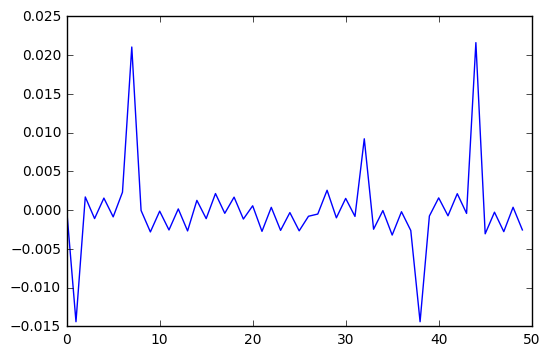

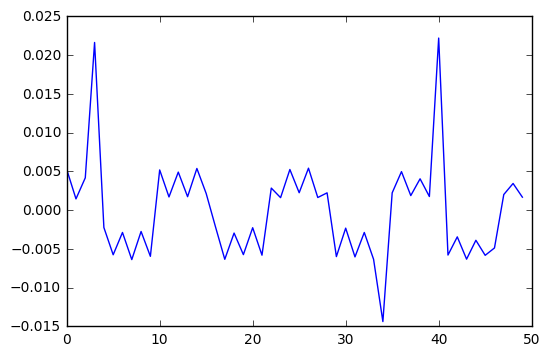

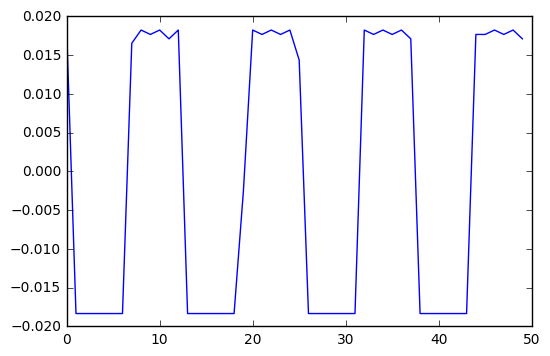

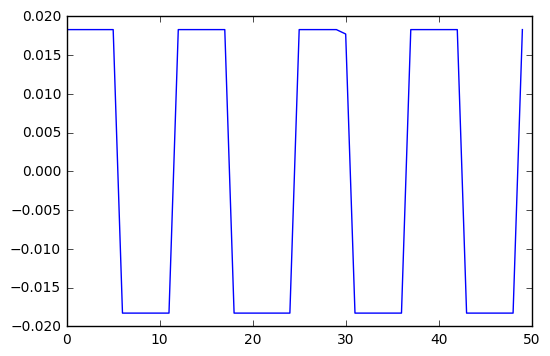

In [229]:
proxy.voltage = 100
proxy.hv_output_enabled = True

plt.figure()

def sample_feedback(i, plot=False, n_samples=50, gain_power=5):
    c = proxy.select_on_board_test_capacitor(i)
    time.sleep(.5)
    sampling_rate, adc_settings, df_volts, df_adc_results = proxy.analog_reads('PGA0', n_samples, gain_power=gain_power)
    v_gnd = np.mean(df_volts)
    v_rms = np.sqrt(np.mean((df_volts - v_gnd)**2))
    v_abs = np.mean(np.abs(df_volts - v_gnd))
    c_meas = v_abs.values[0] / proxy.voltage * 0.15e-6
    if plot:
        plt.figure()
        plt.plot(df_volts.values - v_gnd[0])
    return c_meas

for i in [-1, 0, 1, 2]:
    sample_feedback(i, True)
    
proxy.select_on_board_test_capacitor(-1)
proxy.hv_output_enabled = False

channel 0: 6.71386528015e-12
channel 1: 6.23134231567e-12
channel 2: 5.99762535095e-12
channel 3: 6.17230796814e-12
channel 4: 6.4076385498e-12
channel 5: 7.0860786438e-12
channel 6: 5.60264968872e-12
channel 7: 6.180209198e-12
channel 8: 6.26417633057e-12
channel 9: 6.94730484009e-12
channel 10: 5.84124183655e-12
channel 11: 6.1112562561e-12
channel 12: 4.11263305664e-12 (BAD)
channel 13: 7.15386772156e-12
channel 14: 6.38389778137e-12
channel 15: 5.76023483276e-12
channel 16: 3.19892692566e-12 (BAD)
channel 17: 3.0953931427e-12 (BAD)
channel 18: 6.03918045044e-12
channel 19: 5.9625769043e-12
channel 20: 3.8148348999e-12 (BAD)
channel 21: 3.46765182495e-12 (BAD)
channel 22: 6.94408035278e-12
channel 23: 3.55807067871e-12 (BAD)
channel 24: 4.2306729126e-12 (BAD)
channel 25: 3.73674407959e-12 (BAD)
channel 26: 4.31591033936e-12 (BAD)
channel 27: 7.32104873657e-12
channel 28: 3.77164901733e-12 (BAD)
channel 29: 3.26108551025e-12 (BAD)
channel 30: 6.40964698792e-12
channel 31: 3.850904388

<Container object of 40 artists>

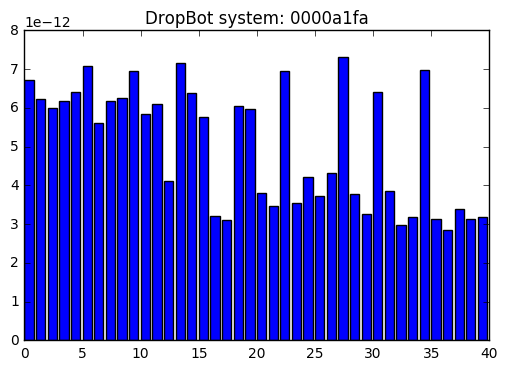

In [243]:
# test channels using the test-board

proxy.voltage = 100
proxy.hv_output_enabled = True

start_time = time.time()
threshold = 5e-12
c = []
for i in range(0, 40):
    state = np.zeros(proxy.number_of_channels)
    state[i] = 1
    proxy.state_of_channels = state
    c.append(sample_feedback(-1, n_samples=50))
    if c[-1] < threshold:
        print "channel %d: %s (BAD)" % (i, c[-1])
    else:
        print "channel %d: %s" % (i, c[-1])

bad_count = np.count_nonzero(np.array(c) < 5e-12)
print "\nTest took %.1f s" % (time.time() - start_time)
print "%d of %d switches bad (%.1f %%)"  % (bad_count, len(c), float(bad_count) / len(c)*100)

plt.title('DropBot system: %s' % str(proxy.uuid)[-8:])
plt.bar(range(len(c)), c)